# The redshift evolution of the BBH merger rate: "a weighty matter"

## Figure 5: the BH primary mass distribution

1. for several redshift bins
2. normalized by the peak rate to emphazise the change in the shape


## Imports and definitions:

In [38]:
######################################
## Imports
import sys
import numpy as np
import h5py as h5

from astropy.table import vstack, Table, Column
import astropy.units as u
from astropy import constants as const

import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u

from matplotlib import ticker, cm

from scipy import stats

# Chosen cosmology 
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value

# Extra python functions
import HelperFunctions as func

######################################
## locations
save_loc    =  '../plots/'
data_dir    = '../output/'

# This will be put in front of the name for every figure we safe 
sim_save_str = 'N1e7_'

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


######################################
## Widescreen jupyter notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


#################################
# Nice little progressbar script 
# to know how far you are with bootstrapping
def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()        
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()

# Read your data

the function `read_data` is part of `HelperFunctions.py` and reads the hdf5 file containing the BBH population data and merger rates. This is expensive memory-wise
Hence the columns specifically needed for this  Figure are loaded right below that

The Bool "DCO_mask" filters for BBHs:  
1. with an inspiral time that is less than the age of the Universe
2. excludes systems that experienced a CE from a HG donor (i.e. the flag `Optimistic_CE == False`)
3. excludes systems that experienced RLOF immediately following a CE (i.e. the flag `Immediate_RLOF>CE == False`)

In other words, we treat 2. and 3. as stellar mergers and exclude them from the rest of our analysis

Lastly, we select merging BBHs using the `DCO_mask`, and aditionally exclude systems that evolve Chemically homogeneous. 


In [6]:
####################################################
## Location of your data
File_location = data_dir+'COMPAS_Output_wWeights.h5'
print(File_location)

# Rate selects wich mergers you are interested in, using a specific SFRD
rate_key      = 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned'

####################################################
'''
The following function will read more information (generally useful for all plots in paper)
Warning, this is heavy on memory usage 
Bare essential data will be read below
DCO, DCO_mask, redshifts, Average_SF_mass_needed, intrinsic_rate_density, intrinsic_rate_density_z0, = func.read_data(loc = File_location, rate_key = rate_key)
DCO.info()
'''

################################################
## Essential data for this plot
## Open hdf5 file and read relevant columns
File        = h5.File(File_location ,'r')

DCO = Table()
DCO['SEED']                  = File['DoubleCompactObjects']['SEED'][()] 
# DCO['Metallicity@ZAMS(1)']   = File['DoubleCompactObjects']['Metallicity@ZAMS(1)'][()] 
DCO['CE_Event_Count']        = File['DoubleCompactObjects']['CE_Event_Count'][()] 
DCO['M_moreMassive']         = np.maximum(File['DoubleCompactObjects']['Mass(1)'][()], File['DoubleCompactObjects']['Mass(2)'][()])
# DCO['mixture_weight']        = File['DoubleCompactObjects']['mixture_weight'][()]

SYS_DCO_seeds_bool           = np.in1d(File['SystemParameters']['SEED'][()], DCO['SEED']) #Bool to point SYS to DCO
DCO['Stellar_Type@ZAMS(1)']  = File['SystemParameters']['Stellar_Type@ZAMS(1)'][SYS_DCO_seeds_bool]

DCO_mask                     = File[rate_key]['DCOmask'][()] # Mask from DCO to merging BBH 
intrinsic_rate_density       = File[rate_key]['merger_rate'][()]
redshifts                    = File[rate_key]['redshifts'][()]

File.close()

################################################
# Bools to select merging BBHs w.o. CHE only
nonCHE_bool         = DCO['Stellar_Type@ZAMS(1)'] != 16
rate_nonCHE_bool    = DCO['Stellar_Type@ZAMS(1)'][DCO_mask] != 16

# Filter both the BBH table and the intrinsic rate data
merging_BBH         = DCO[DCO_mask * nonCHE_bool]
Red_intr_rate_dens  = intrinsic_rate_density[rate_nonCHE_bool, :]


../output/COMPAS_Output_wWeights.h5


# Mass distribution:  split by redshift or channel

In [72]:
# Distribution plot function
def plot_dist_by_redshift(tables, x_key, crude_rate_densities, log = False, kde_width = 0.1, 
                          bootstrap  = False, bootstraps = 100, fill=True, show_hist = False,
                          normalize_by_peak = False, annotate_stuff=True, bins = np.arange(0,50,2),  
                          savestr = '', save_plot=False, x_lim=(0,50), y_lim = (0,1000), 
                          colors = ['#488496', '#73bdb3', '#e388b0'], hatch = ['','','','','',''],
                          labels = ['$%s \leq z < %s$'%(0.,2.)],
                          xlabel = '$M_{\mathrm{BH,1} \ } [\mathrm{M_{\odot}} ]$',
                          ylabel = r'$R_{\mathrm{BBH} \ \mathrm{[Gpc^{-3} \ yr^{-1} \ M_{\odot}^{-1}}]}$',
                          titlestr = '',
                         leg_args = None):
    
    #########################################
    mass_binw = np.diff(bins)[0]
    #########################################
    # Start plotting
    fig, ax = plt.subplots(figsize = (12, 8))
    
    
    # Loop over all tables (if more than one)
    for t, table in enumerate(tables):        
        ##############################
        ## Average rate density per z-bin
        crude_rate_density = crude_rate_densities[t]

        # If you want to re-normalize the dist
        norm = 1.

        # X value and weight
        x_vals       = table[x_key]
        
        #########################################
        i, Nredshiftbins = 0,10
        while i < Nredshiftbins:
            print('crude bin i = ', i)            
            if crude_rate_density.ndim > 1:
                Nredshiftbins = len(crude_rate_density[0,:])
                m_Weight      = crude_rate_density[:,i]
                color_i       = i
            else:
                Nredshiftbins = 1
                m_Weight      = crude_rate_density
                color_i       = t
            
            ########################
            # Get the Hist    
            hist, bin_edge = np.histogram(x_vals, weights = m_Weight, bins=bins)
            center_bins = (bin_edge[:-1] + bin_edge[1:])/2.
            # And the KDE
            kernel = stats.gaussian_kde(x_vals, bw_method=kde_width, weights=m_Weight)
            binwidth = np.diff(bin_edge)

            if normalize_by_peak:
                norm = max(hist/mass_binw)

            ########################
            # Plot the Hist 
            if show_hist:
                y_vals = hist/mass_binw/norm
                ax.bar(center_bins, y_vals, width= np.diff(bins), 
                       alpha=1.0, fill=False, edgecolor=colors[color_i],lw = 1., zorder = i) 
                print('sum(hist)', sum(hist), 'sum(hist*mass_binw)', sum(hist*mass_binw) )

            ########################
            # Add KDE
            show_KDE = True
            if show_KDE:
                x_KDE = np.arange(2.5,bins[-1],0.1)
                KDEy_vals = kernel(x_KDE)*sum(hist)/norm #re-normalize the KDE
                ax.plot(x_KDE, KDEy_vals,label = labels[color_i],  color=colors[color_i], lw=5,  zorder =i+1)
                if fill:
                    ax.fill_between(x_KDE, y1=0, y2=KDEy_vals, color=colors[color_i], alpha = 0.05, zorder = i+1)
                    ax.fill_between(x_KDE, y1=0, y2=KDEy_vals, facecolor="none", edgecolor=colors[color_i], hatch = hatch[color_i], alpha = 0.95, lw = 2, zorder = i+2)


            ########################
            # Bootstrap        
            if bootstrap:
                indices = np.arange(len(x_vals))
                hist_vals = np.zeros((bootstraps, len(x_KDE)))  #center_bins
                for b in range(len(hist_vals)):
                    print('boostrap b=', b)

                    boot_index = np.random.choice(indices, size=len(indices), replace=True)

                    kernel       = stats.gaussian_kde(x_vals[boot_index], bw_method=kde_width, weights=m_Weight[boot_index])
                    Hist, _      = np.histogram(x_vals[boot_index], bins=bins,weights=m_Weight[boot_index],density=False)

                    norm         = max(Hist/mass_binw)

                    hist_vals[b] = kernel(x_KDE)*sum(Hist)/norm

                # calculate 1- and 2- sigma percentiles
                percentiles = np.percentile(hist_vals, [15.89, 84.1, 2.27, 97.725], axis=0)
                median = np.percentile(hist_vals, [50], axis=0)

                # plot uncertainties as filled areas
                ax.fill_between(x_KDE, percentiles[0],percentiles[1], alpha=0.4, color=colors[color_i], zorder = 11) # 1-sigma
                ax.fill_between(x_KDE, percentiles[2], percentiles[3],alpha=0.2, color=colors[color_i], zorder = 10) # 2-sgima    

            i +=1

    # annotate where all the peaks should be
    if annotate_stuff:
        ax.annotate(text='$\mathrm{peak \ rate}$',  xy=(15, 4e1), xytext = (6.5, 4e1), #xy=(15, 8.5e2), xytext = (6.5, 1.15e3), 
                    arrowprops=dict(facecolor='grey', arrowstyle='->'), rotation=0, color = 'k', size = 20)        
        ax.annotate(text='$\mathrm{transition \ CCSN - PPISN}$', xy=(33, 2e0), xytext = (25, 2e1), #xy=(33, 8e1), xytext = (25, 5e2), 
                    arrowprops=dict(facecolor='grey',  arrowstyle='->'), size = 20, color = 'k')
        
        ax.annotate(text='$\mathrm{PPISN \ pile-up}$',  ha='center', xy=(44, 8e-1), xytext = (43, 5e0),#xy=(44, 2e1), xytext = (43, 8e1),
                    arrowprops=dict(facecolor='grey',  arrowstyle='->'), size = 20, color = 'k')

    #########################################
    # plot values
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    leg = ax.legend(fontsize = 22, **leg_args)

    plt.title(titlestr)

    ax.set_xlabel(xlabel, fontsize = 30)
    ax.set_ylabel(ylabel, fontsize = 30)
    if log:
        ax.set_yscale('log')
        
    if save_plot:
        plt.savefig(save_loc+'/'+savestr+'Mass_dist_by_redshift.pdf', bbox_inches='tight')
        plt.savefig(save_loc+'/png_versions/'+savestr+'Mass_dist_by_redshift.png', bbox_inches='tight')

    plt.show()


    

# Mass distribution split by channels

i_per_crude_bin 10.0
crude bin i =  0
crude bin i =  0
crude bin i =  0


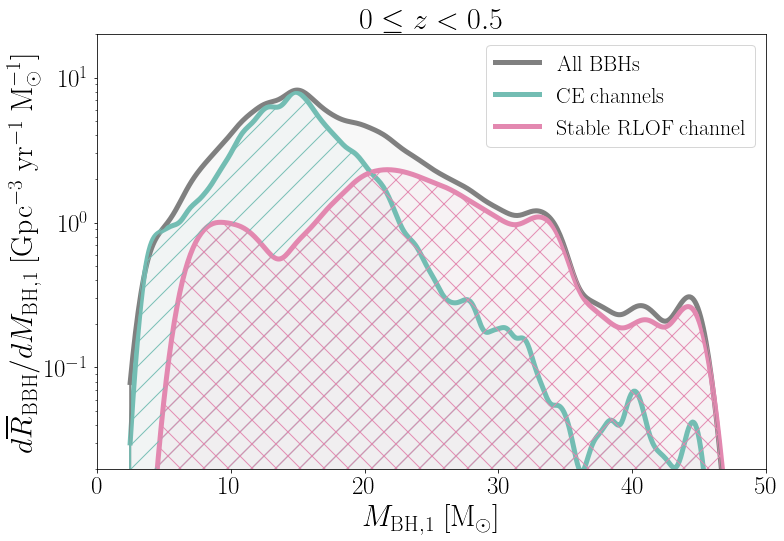

In [68]:
z_bin_edges = np.array([0,0.5])

##########################################
## Calculate average rate density per z-bin
crude_rate_density    = func.get_crude_rate_density(Red_intr_rate_dens[:,:], redshifts, z_bin_edges)
weights               = crude_rate_density[:,0]

# CE channel
BBH_CEchannel         = merging_BBH[merging_BBH['CE_Event_Count'] >0]
CEchannel_weights     = weights[merging_BBH['CE_Event_Count'] >0]

# stable RLOF channel
BBH_stablechannel     = merging_BBH[merging_BBH['CE_Event_Count'] == 0]
stablechannel_weights = weights[merging_BBH['CE_Event_Count'] == 0]


#All BBH (uses vstack to allow further cuts in CE and stable channel)
all_BBH               = vstack([BBH_CEchannel, BBH_stablechannel])
all_weights           = np.append(CEchannel_weights, stablechannel_weights)

##########################################

#Full z range
plot_dist_by_redshift([all_BBH, BBH_CEchannel,BBH_stablechannel], 'M_moreMassive', [all_weights, CEchannel_weights,stablechannel_weights], normalize_by_peak = False,
                      bootstrap  = False, bootstraps = 50, bins = np.arange(0,50,1), labels=['$\mathrm{All \ BBHs}$', '$\mathrm{CE \ channels}$', '$\mathrm{Stable \ RLOF \ channel}$'],
                      show_hist = False, annotate_stuff=False,
                      colors = ['grey', '#73bdb3',  '#e388b0'], hatch = ['','/','x'], y_lim = (2e-2,20),
                      log = True, savestr = sim_save_str+'_channels', save_plot=True, 
                      ylabel = r'$d\overline{R}_{\mathrm{BBH}}/dM_{\mathrm{BH,1}} \ \mathrm{[Gpc^{-3} \ yr^{-1} \ M_{\odot}^{-1}]}$',
                      leg_args = {'loc':'upper right'}, titlestr = '$%s\leq z <%s$'%(z_bin_edges[0],z_bin_edges[1]))




# Mass distribution at different redshifts

i_per_crude_bin 40.0
np.shape(crude_rate_density) (2252487, 5)
!!! 5
crude bin i =  0
6 6
crude bin i =  1
6 6
crude bin i =  2
6 6
crude bin i =  3
6 6
crude bin i =  4
6 6


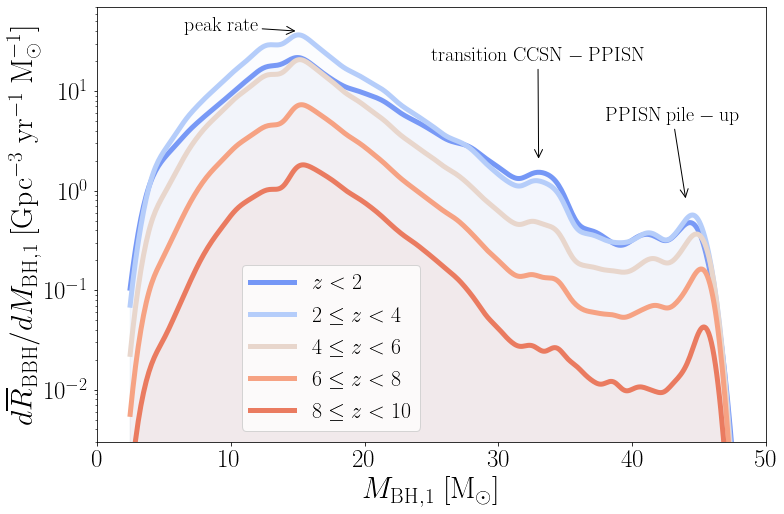

In [31]:
z_bin_edges = np.array([0,2,4,6,8,10])

##########################################
# centers of redshif bins
center_z = (redshifts[:-1] + redshifts[1:])/2.
#Centers of your crude redshift bins
center_Crude_bins = (z_bin_edges[:-1] + z_bin_edges[1:])/2. # center points

##########################################
# labels based on z_bin_edges
labels     = ['$%s \leq z < %s$'%(z_bin_edges[a],z_bin_edges[a+1]) for a in range(0,len(z_bin_edges)-1) ]
labels[0]  = '$z < %s$'%(z_bin_edges[1])
labels.append('$z \geq %s$'%(z_bin_edges[-1]))


##########################################
## Calculate average rate density per z-bin
crude_rate_density = func.get_crude_rate_density(Red_intr_rate_dens, redshifts, z_bin_edges)


##########################################
kleuren = sns.color_palette("coolwarm", 10)
indexes = [1,3,5,7,8,9]

#Full z range
plot_dist_by_redshift([merging_BBH], 'M_moreMassive', [crude_rate_density], normalize_by_peak = False,
                      bootstrap  = False, bootstraps = 50,
                      bins = np.arange(0,50,1), labels = labels,
                      colors = [kleuren[e] for e in indexes], y_lim = (3e-3,7e1), 
                      log = True, savestr = sim_save_str+'log', save_plot=False, 
                      show_hist = False, annotate_stuff=True,
                      ylabel = r'$d\overline{R}_{\mathrm{BBH}}/dM_{\mathrm{BH,1}} \ \mathrm{[Gpc^{-3} \ yr^{-1} \ M_{\odot}^{-1}]}$',
                      leg_args = {'bbox_to_anchor':(0.2,0.), 'loc':'lower left'})




# Mass distribution normalised by the peak 

i_per_crude_bin 10.0
crude bin i =  0
crude bin i =  1
crude bin i =  2
crude bin i =  3


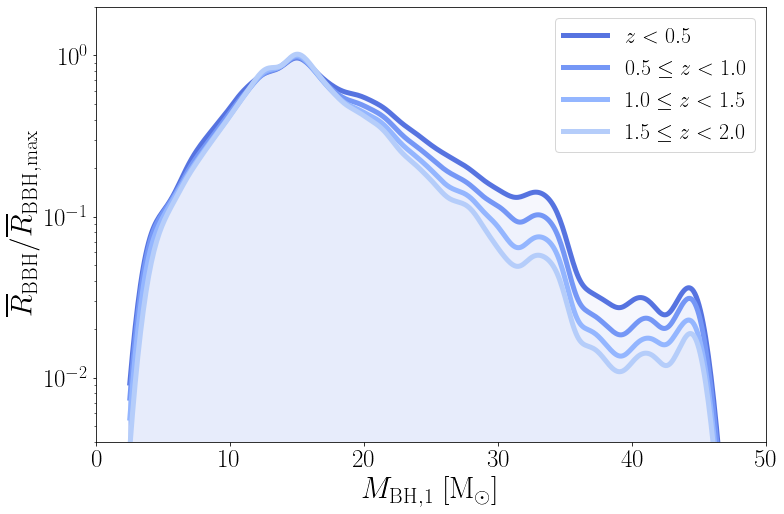

In [73]:
z_bin_edges = np.array([0,0.5,1,1.5,2])

##########################################
# centers of redshif bins
center_z = (redshifts[:-1] + redshifts[1:])/2.
#Centers of your crude redshift bins
center_Crude_bins = (z_bin_edges[:-1] + z_bin_edges[1:])/2. # center points

##########################################
# labels based on z_bin_edges
labels     = ['$%s \leq z < %s$'%(z_bin_edges[a],z_bin_edges[a+1]) for a in range(0,len(z_bin_edges)-1) ]
labels[0]  = '$z < %s$'%(z_bin_edges[1])
labels.append('$z \geq %s$'%(z_bin_edges[-1]))


##########################################
## Calculate average rate density per z-bin
crude_rate_density = func.get_crude_rate_density(Red_intr_rate_dens, redshifts, z_bin_edges)


##########################################
kleuren = sns.color_palette("coolwarm", 10)
indexes = [0,1,2,3,5]

#Lower redshifts, normalized by peak
plot_dist_by_redshift([merging_BBH], 'M_moreMassive', [crude_rate_density], normalize_by_peak = True,
                      annotate_stuff=False, bootstrap  = False, bootstraps = 1,  
                      bins = np.arange(0,50,1.), labels = labels,
                      fill = True, ylabel = r'$\overline{R}_{\mathrm{BBH}}/\overline{R}_{\mathrm{BBH, max}}$',
                      colors = [kleuren[e] for e in indexes], y_lim = (4e-3,2), 
                      log = True, savestr = sim_save_str+'_normed_', save_plot=True,
                     leg_args = {'loc':'upper right'})
